# CS522 - Final Project
The objective of the final project is to integrate various machine learning techniques to achieve the best performance. Final project is a group effort. Each group can have 4-5 members. You are required to apply ALL techniques learned in this semester.

## Schedule
- (5) Milestone 1 (Due 11/4): Group Formation and Topic selection. Submit through Canvas. Approval and comments will be returned in one day. The same topic cannot be chosen by more than 1 group. The topic follows the first-come first-served rule. So pick a topic as soon as possible.
- (5) Milestone 2 - Literature Survey (Due 11/11): Background study including references and state-of-the-art performance on the dataset (2-page report need to be submitted).
- (5) Milestone 3 - Prototype 1 (Due 11/18): Prototype, preliminary results and task allocation among group members. Apply at least one learned technique successfully for each component in the pipeline on the chosen dataset and submit a 1-page report.
- (5) Milestone 4 - Prototype 2 (Due 12/02): Implement at least two solutions to each component of the pipeline. Determine what metrics to use. Provide performance evaluation results.
- (100) Final presentation (Due 12/08)(Presentation slides due the midnight before the presentation on 12/9. Submit through Canvas)
- (80) Final report (Due 12/10). Submit through Canvas.

## Potential Topics
Each group can choose one topic from the following sources. All selection needs to be approved by instructor.
- KDD-Cup 1997-2009
- Kaggle Competitions
- Other topics: You can select a topic yourself from other resources.

## Requirement
General steps involved in a machine learning problem include
- Data collection (raw data)
- Feature extraction (how to extract features from the raw data)
- Feature selection (dimensionality reduction - Fisher's linear discriminant or PCA)
- Classification/Regression methods need to be included
    - Supervised learning and Unsupervised learning
    - Baysian approaches and non-Baysian approaches
    - Parametric and Non-parametric density estimation in supervised learning
    - Fusion
- Performance evaluation
- Feedback system

You are required to evaluate the effect of various aspects of the classification/regression process, including but not limited to
- the effect of assuming the data is Gaussian-distributed
- the effect of assuming parametric pdf vs. non-parametric pdf
- the effect of using different prior probability ratio
- the effect of using different distance
- the effect of knowing the class label
- the effect of dimension of the feature space (e.g., changed through dimensionality reduction)
- the effect of fusion

To be more specific, you need to at least go through the following steps:
- Data normalization
- Dimensionality reduction
    - Classification/Regression with the following
    - MPP (case 1, 2, and 3)
    - kNN with different k's
    - BPNN
    - Decision tree
    - SVM
    - Clustering (kmeans, wta)
- Classifier fusion
- Evaluation (use n-fold cross validation to generate confusion matrix and ROC curve if applicable).

# 1. Data collection (raw data) - Face Mask 12k Images Dataset
- URL: [https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset](https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset)

This dataset is used for Face Mask Detection Classification with images. The dataset consists of almost 12K images which are almost 328.92MB in size.

"All the images with the face mask (~6K) are scrapped from google search and all the images without the face mask are preprocessed from the CelebFace dataset created by Jessica Li (https://www.kaggle.com/jessicali9530). Thank you so much Jessica for providing a wonderful dataset to the community."


In [1]:
%load_ext autoreload
%autoreload 2

# IMPORT LIBRARIES

In [2]:
# IMPORT OUR OWN FILES

from Dataset import *
from PreProcessing import *
from convolution import *

In [3]:
# MISCELLANEOUS ROUTINES

# make directory to save generated images to
os.makedirs('img', exist_ok=True)

## 1.1. Read In Data
Throughout this project:
- 0 corresponds to not wearing a mask
- 1 corresponds to wearing a mask

In [4]:
dataset = Dataset(dataset_dir=os.path.join("datasets", "face_mask"))
dataset.load_all()

print(dataset)

# Dataset Init: datasets/face_mask
	- Loading Datasets...
	=> TRAIN
		- With Mask: 5000 (50.0%)
		- No Mask: 5000 (50.0%)
		- Total: 10000
	=> VALIDATION
		- With Mask: 400 (50.0%)
		- No Mask: 400 (50.0%)
		- Total: 800
	=> TEST
		- With Mask: 483 (48.69%)
		- No Mask: 509 (51.31%)
		- Total: 992
# Loading Train Set...


100%|██████████| 10000/10000 [00:07<00:00, 1379.05it/s]


# Loading Validation Set...


100%|██████████| 800/800 [00:00<00:00, 1431.38it/s]


# Loading Test Set...


100%|██████████| 992/992 [00:00<00:00, 1438.96it/s]

	- Datasets Loaded!
# Dataset Info: datasets/face_mask
	- Train: 10000 (84.8%)
	- Validation: 800 (6.78%)
	- Test: 992 (8.41%)
	- Total: 11792


## 1.2. Normalizing dataset
Need to standardize the size of the images.
It is conventional to resize all of the images to the smallest image in the dataset.
https://datascience.stackexchange.com/questions/40462/how-to-prepare-the-varied-size-input-in-cnn-prediction



In [5]:
def t_resize(X):
    # resize training data
    return PreProcessing.resize_images(X, size=(128, 128, 3))


dataset.transform(t_resize)


def t_grayscale(X):
    return PreProcessing.dataset2grayscale(X)


dataset_gray = dataset.copy_transform(t_grayscale)


def t_scale(X):
    return PreProcessing.min_max_scale_dataset(X)


dataset.transform(t_scale)
dataset_gray.transform(t_scale)

# Performing Feature Set Transformation: t_resize
	- 1/3


10000it [00:05, 1713.04it/s]


	- 2/3


800it [00:00, 1749.36it/s]


	- 3/3


992it [00:00, 1955.32it/s]


# Performing Feature Set Transformation: t_grayscale
	- 1/3


100%|██████████| 10000/10000 [00:00<00:00, 12230.89it/s]


	- 2/3


100%|██████████| 800/800 [00:00<00:00, 11649.51it/s]


	- 3/3


100%|██████████| 992/992 [00:00<00:00, 9635.62it/s]


# Performing Feature Set Transformation: t_scale
	- 1/3


100%|██████████| 10000/10000 [00:01<00:00, 6662.05it/s]


	- 2/3


100%|██████████| 800/800 [00:00<00:00, 5878.15it/s]


	- 3/3


100%|██████████| 992/992 [00:00<00:00, 6218.39it/s]


# Performing Feature Set Transformation: t_scale
	- 1/3


100%|██████████| 10000/10000 [00:00<00:00, 26225.63it/s]


	- 2/3


100%|██████████| 800/800 [00:00<00:00, 41114.08it/s]


	- 3/3


100%|██████████| 992/992 [00:00<00:00, 29452.88it/s]


## 1.3. Peek at Dataset
In order to get a feel for the data, lets look at some of the images

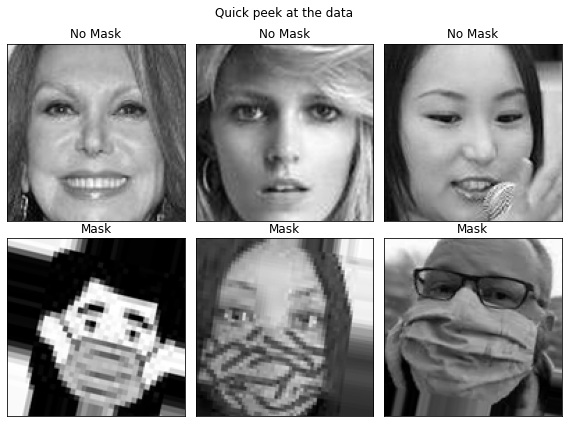

In [7]:
def plot_img_grid(img, label, size, pos):
    """
    given the image, its label, the size of the grid, and its position on the grid,
    create a grid of images displaying images in the dataset
    """
    ax = plt.subplot2grid(size, pos)
    ax.tick_params(left=False, right=False, labelleft=False,
                   labelbottom=False, bottom=False)
    ax.title.set_text(label)
    ax.imshow(img, cmap='gray')


fig = plt.figure(figsize=(8, 6))
fig.suptitle('Quick peek at the data')
plot_img_grid(dataset_gray.train.X[0], 'No Mask', (2, 3), (0, 0))
plot_img_grid(dataset_gray.train.X[1000], 'No Mask', (2, 3), (0, 1))
plot_img_grid(dataset_gray.train.X[2000], 'No Mask', (2, 3), (0, 2))
plot_img_grid(dataset_gray.train.X[7000], 'Mask', (2, 3), (1, 0))
plot_img_grid(dataset_gray.train.X[8001], 'Mask', (2, 3), (1, 1))
plot_img_grid(dataset_gray.train.X[9004], 'Mask', (2, 3), (1, 2))
plt.tight_layout()
plt.savefig('./img/faces.png', dpi=500)
plt.show()


# 2. Feature extraction
Objective: how to extract features from the raw data

# 2.1. Convolutional Neural Network (CNN)

![CNN Hierarchy](img/cnn_hierarchy.png)

Build Layers and Sequential Model for the convolution


Model: Sequential

#    Layer
0    input_layer (Conv3d)
1    activation (Activation)
2    pooling1 (MaxPooling2D)
3    layer1 (Conv3d)
4    activation (Activation)
5    pooling1 (MaxPooling2D)


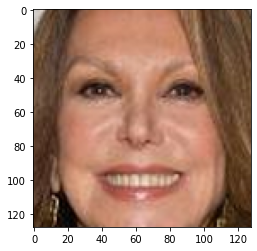

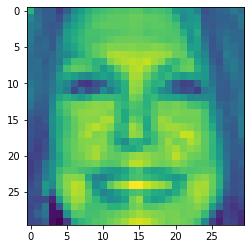

In [8]:
def get_cnn_rgb(flatten: bool):
    kernel = np.array([[[1, -1, 1], [-1, 8, -1], [1, -1, 1]], [[1, -1, 1], [-1, 8, -1], [1, -1, 1]],
                       [[1, -1, 1], [-1, 8, -1], [1, -1, 1]]])  # 3d kernel needed for 3d image

    model = Sequential()
    model.add(Conv(kernel=kernel, name="input_layer"))
    model.add(Activation('relu'))
    model.add(Pooling2D(pool_size=2, stride=2, padding=0, mode='avg', name="pooling1"))
    model.add(Conv(kernel=kernel, name="layer1"))
    model.add(Activation('relu'))
    model.add(Pooling2D(pool_size=2, stride=2, padding=0, mode='avg', name="pooling1"))
    if flatten:
        model.add(Flatten())
    model.summary()
    return model


test_image = dataset.train.X[0]
x = get_cnn_rgb(flatten=False).feedforward(test_image)

# display original image
plt.imshow(test_image)
plt.show()

# display convolved image
plt.imshow(x)
plt.show()

(4, 3, 3)
Model: Sequential

#    Layer
0    input_layer (Conv2d)
1    pooling_2d (MaxPooling2D)
2    input_layer (Conv2d)
3    activation (Activation)
4    pooling_2d (MaxPooling2D)


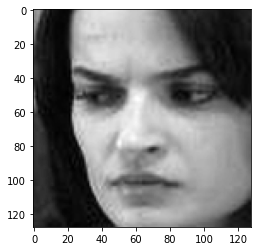

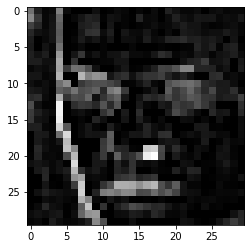

(4, 3, 3)
Model: Sequential

#    Layer
0    input_layer (Conv2d)
1    pooling_2d (MaxPooling2D)
2    input_layer (Conv2d)
3    activation (Activation)
4    pooling_2d (MaxPooling2D)


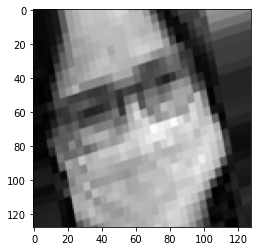

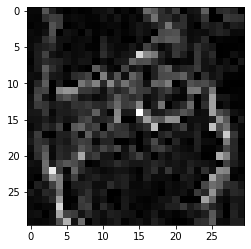

(4, 3, 3)
Model: Sequential

#    Layer
0    input_layer (Conv2d)
1    pooling_2d (MaxPooling2D)
2    input_layer (Conv2d)
3    activation (Activation)
4    pooling_2d (MaxPooling2D)


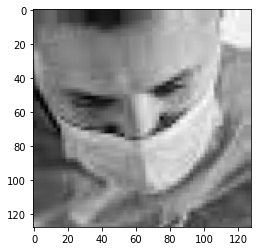

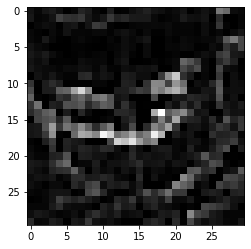

(4, 3, 3)
Model: Sequential

#    Layer
0    input_layer (Conv2d)
1    pooling_2d (MaxPooling2D)
2    input_layer (Conv2d)
3    activation (Activation)
4    pooling_2d (MaxPooling2D)


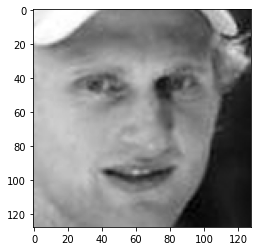

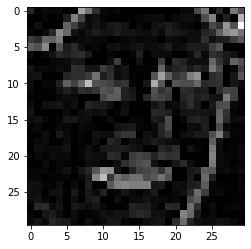

(4, 3, 3)
Model: Sequential

#    Layer
0    input_layer (Conv2d)
1    pooling_2d (MaxPooling2D)
2    input_layer (Conv2d)
3    activation (Activation)
4    pooling_2d (MaxPooling2D)


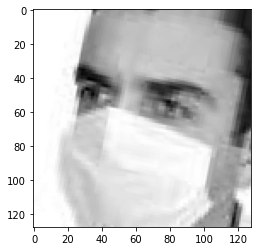

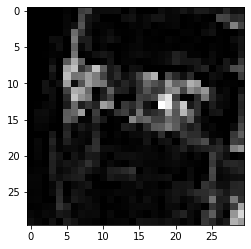

(4, 3, 3)
Model: Sequential

#    Layer
0    input_layer (Conv2d)
1    pooling_2d (MaxPooling2D)
2    input_layer (Conv2d)
3    activation (Activation)
4    pooling_2d (MaxPooling2D)


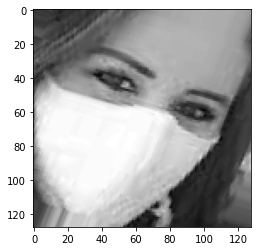

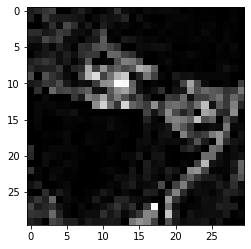

(4, 3, 3)
Model: Sequential

#    Layer
0    input_layer (Conv2d)
1    pooling_2d (MaxPooling2D)
2    input_layer (Conv2d)
3    activation (Activation)
4    pooling_2d (MaxPooling2D)


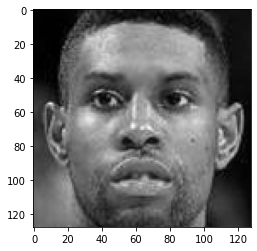

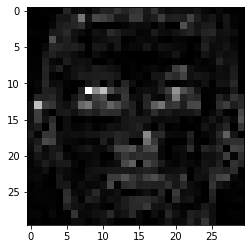

(4, 3, 3)
Model: Sequential

#    Layer
0    input_layer (Conv2d)
1    pooling_2d (MaxPooling2D)
2    input_layer (Conv2d)
3    activation (Activation)
4    pooling_2d (MaxPooling2D)


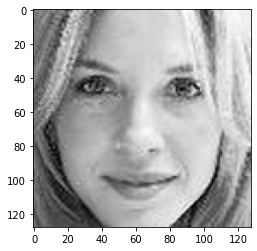

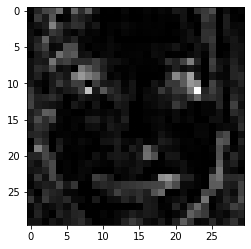

(4, 3, 3)
Model: Sequential

#    Layer
0    input_layer (Conv2d)
1    pooling_2d (MaxPooling2D)
2    input_layer (Conv2d)
3    activation (Activation)
4    pooling_2d (MaxPooling2D)


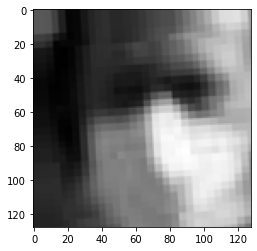

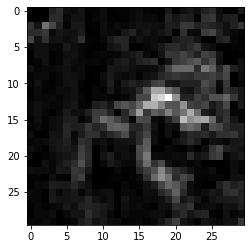

(4, 3, 3)
Model: Sequential

#    Layer
0    input_layer (Conv2d)
1    pooling_2d (MaxPooling2D)
2    input_layer (Conv2d)
3    activation (Activation)
4    pooling_2d (MaxPooling2D)


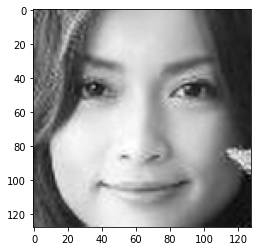

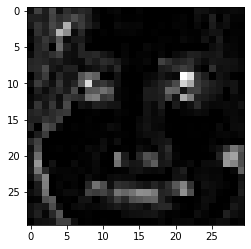

(4, 3, 3)
Model: Sequential

#    Layer
0    input_layer (Conv2d)
1    pooling_2d (MaxPooling2D)
2    input_layer (Conv2d)
3    activation (Activation)
4    pooling_2d (MaxPooling2D)


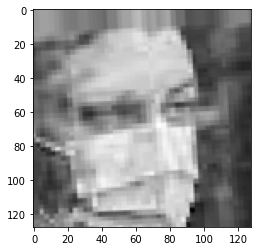

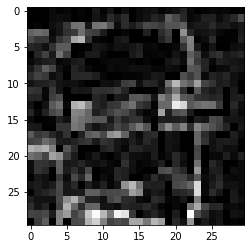

(4, 3, 3)
Model: Sequential

#    Layer
0    input_layer (Conv2d)
1    pooling_2d (MaxPooling2D)
2    input_layer (Conv2d)
3    activation (Activation)
4    pooling_2d (MaxPooling2D)


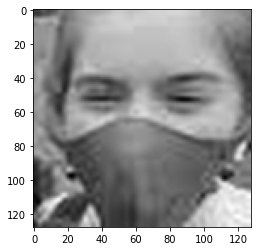

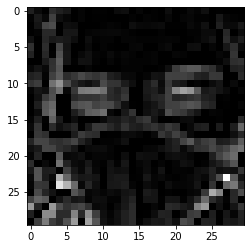

(4, 3, 3)
Model: Sequential

#    Layer
0    input_layer (Conv2d)
1    pooling_2d (MaxPooling2D)
2    input_layer (Conv2d)
3    activation (Activation)
4    pooling_2d (MaxPooling2D)


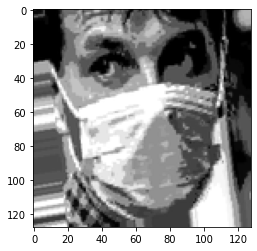

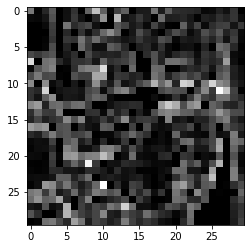

(4, 3, 3)
Model: Sequential

#    Layer
0    input_layer (Conv2d)
1    pooling_2d (MaxPooling2D)
2    input_layer (Conv2d)
3    activation (Activation)
4    pooling_2d (MaxPooling2D)


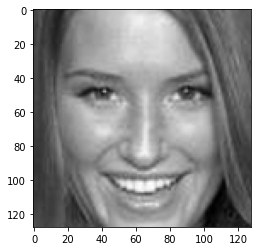

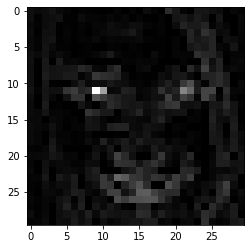

(4, 3, 3)
Model: Sequential

#    Layer
0    input_layer (Conv2d)
1    pooling_2d (MaxPooling2D)
2    input_layer (Conv2d)
3    activation (Activation)
4    pooling_2d (MaxPooling2D)


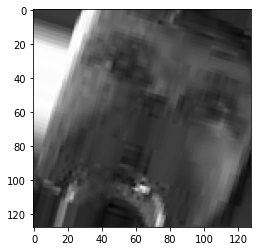

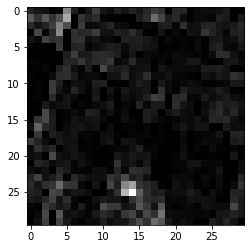

(4, 3, 3)
Model: Sequential

#    Layer
0    input_layer (Conv2d)
1    pooling_2d (MaxPooling2D)
2    input_layer (Conv2d)
3    activation (Activation)
4    pooling_2d (MaxPooling2D)


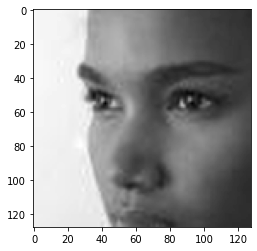

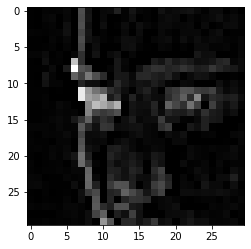

(4, 3, 3)
Model: Sequential

#    Layer
0    input_layer (Conv2d)
1    pooling_2d (MaxPooling2D)
2    input_layer (Conv2d)
3    activation (Activation)
4    pooling_2d (MaxPooling2D)


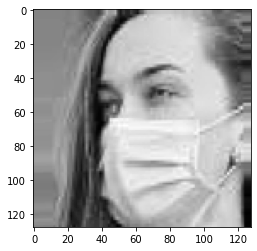

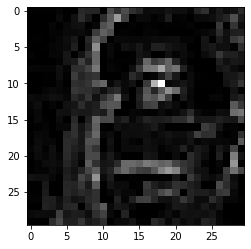

(4, 3, 3)
Model: Sequential

#    Layer
0    input_layer (Conv2d)
1    pooling_2d (MaxPooling2D)
2    input_layer (Conv2d)
3    activation (Activation)
4    pooling_2d (MaxPooling2D)


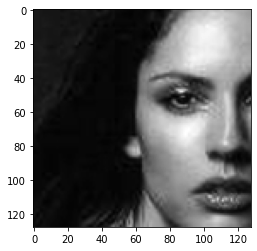

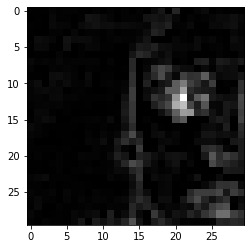

(4, 3, 3)
Model: Sequential

#    Layer
0    input_layer (Conv2d)
1    pooling_2d (MaxPooling2D)
2    input_layer (Conv2d)
3    activation (Activation)
4    pooling_2d (MaxPooling2D)


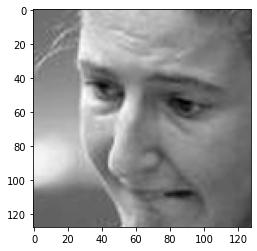

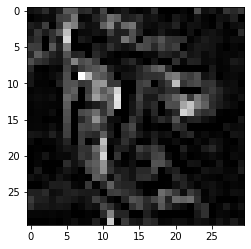

(4, 3, 3)
Model: Sequential

#    Layer
0    input_layer (Conv2d)
1    pooling_2d (MaxPooling2D)
2    input_layer (Conv2d)
3    activation (Activation)
4    pooling_2d (MaxPooling2D)


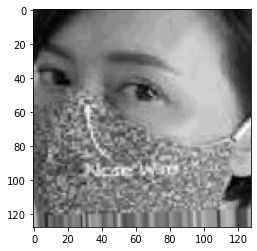

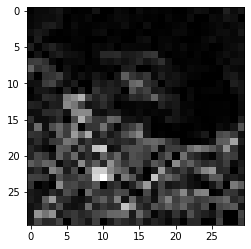

In [126]:

def get_cnn_gray(flatten: bool):
    # convolution kernel
    # kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]) # sharper images
    kernel = np.array([[0, -1, 0], [-1, 6, -1], [0, -1, 0]])  # sharper images
    # kernel = np.array([[-1, -1, -1], [-1, 0, -1], [-1, -1, -1]])
    # kernel = np.array([[[-1, 0, -1], [-1, 0, -1], [-1, 0, -1]],
    #                    [[-1, 0, -1], [-1, 0, -1], [-1, 0, -1]],
    #                    [[-1, 0, -1], [-1, 0, -1], [-1, 0, -1]]])
    # kernel = np.array([[0,1,2,1,0], [1,4,8,4,1], [2,8,16,8,2], [1,4,8,4,1],[0,1,2,1,0]]) # smoothing
    # kernel = np.array([[0, 1, 0], [1, 4, 1], [0, 1, 0]])  # gaussian blur

    k_sharpen = np.array(
        [[0, -1, 0], [-1, 10, -1], [0, -1, 0]])  # sharper images

    k_outline = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])  # outline
    k_emboss = np.array([[-2, -1, 0], [-1, 1, 1], [0, 1, 2]])  # emboss

    k_blur = np.array([[0, 1, 0], [1, 4, 1], [0, 1, 0]])  # gaussian blur

    k_test = np.array([[-1, -1, -1],
                       [-1, 100, -1],
                       [-1, -1, -1]])
    
    k_test1 = np.array([[-1, -1, -1],
                       [1.15, 1.15, 1.15],
                       [-1, -1, -1]])
    
    k_test2 = np.array([[-1, 1.15, -1],
                       [-1, 1.15,-1],
                       [-1, 1.15, -1]])
    
    k_test3 = np.array([[-1, -1, 1.15],
                       [-1, 1.15, -1],
                       [1.15, -1, -1]])
    
    k_test4 = np.array([[1.15, -1, -1],
                       [-1, 1.15, -1],
                       [-1, -1, 1.15]])
    
    
    k_test_app = []
    
    k_test_app.append(k_test1)
    k_test_app.append(k_test2)
    k_test_app.append(k_test3)
    k_test_app.append(k_test4)


    k_test_app = np.array(k_test_app)
    print(k_test_app.shape)
    
    
    # build model
    model = Sequential()

    model.add(Conv(kernel=k_test1, name="input_layer"))
    model.add(Pooling2D(mode='max'))

    # model.add(Activation('relu'))

    # model.add(Conv(kernel=k_test1, name="input_layer"))
    # model.add(Activation('sigmoid'))
    
    # model.add(Conv(kernel=k_test2, name="input_layer"))
    # model.add(Activation('sigmoid'))
    
    # model.add(Conv(kernel=k_test3, name="input_layer"))
    # model.add(Activation('sigmoid'))

    # model.add(Conv(kernel=k_test4, name="input_layer"))
    # model.add(Activation('sigmoid'))


    model.add(Conv(kernel=k_outline, name="input_layer"))
    model.add(Activation('relu'))


    model.add(Pooling2D(mode='max'))
    # model.add(Conv(kernel=k_outline, name="input_layer"))
    # model.add(Activation('relu'))
    # model.add(Conv(kernel=k_sharpen, name="input_layer"))
    # model.add(Activation('relu'))
    # model.add(Conv(kernel=k_emboss, name="input_layer"))
    if (flatten):
        model.add(Flatten())
    # model.add(Activation('sigmoid'))
    model.summary()
    return model


for i in range(20):
    randint = np.random.randint(0, len(dataset.train.X))
    test_image_gray = dataset_gray.train.X[randint]
    # feed image through model
    x = get_cnn_gray(flatten=False).feedforward(test_image_gray)

    # display original image
    plt.imshow(test_image_gray, cmap='gray')
    plt.show()

    # display convoluted image
    plt.imshow(x, cmap='gray')
    plt.show()


In [127]:
from tqdm import tqdm
model_cnn_rgb = get_cnn_rgb(flatten=True)
model_cnn_gray = get_cnn_gray(flatten=True)

def t_conv_rgb(X):
    conv = np.array([model_cnn_rgb.feedforward(x) for x in tqdm(X)])
    return conv

def t_conv_gray(X):
    conv = np.array([model_cnn_gray.feedforward(x) for x in tqdm(X)])
    return conv

dataset.transform(t_conv_rgb)
dataset_gray.transform(t_conv_gray)

Model: Sequential

#    Layer
0    input_layer (Conv3d)
1    activation (Activation)
2    pooling1 (MaxPooling2D)
3    layer1 (Conv3d)
4    activation (Activation)
5    pooling1 (MaxPooling2D)
6    flatten (Flatten)
(4, 3, 3)
Model: Sequential

#    Layer
0    input_layer (Conv2d)
1    pooling_2d (MaxPooling2D)
2    input_layer (Conv2d)
3    activation (Activation)
4    pooling_2d (MaxPooling2D)
5    flatten (Flatten)
# Performing Feature Set Transformation: t_conv_rgb
	- 1/3


100%|██████████| 10000/10000 [10:28<00:00, 15.92it/s]


	- 2/3


100%|██████████| 800/800 [00:51<00:00, 15.68it/s]


	- 3/3


100%|██████████| 992/992 [01:02<00:00, 15.98it/s]


# Performing Feature Set Transformation: t_conv_gray
	- 1/3


100%|██████████| 10000/10000 [09:24<00:00, 17.72it/s]


	- 2/3


100%|██████████| 800/800 [00:46<00:00, 17.09it/s]


	- 3/3


100%|██████████| 992/992 [00:56<00:00, 17.45it/s]


In [128]:
# Save transformed dataset objects to file
dirpath = os.path.join('datasets', 'face_mask_pickled')

dataset.save_gzip(dir_path=dirpath, file_name="dataset_conv.pkl.gzip", overwrite=True)
dataset_gray.save_gzip(dir_path=dirpath, file_name="dataset_gray_conv.pkl.gzip", overwrite=True)

[autoreload of numpy.core.multiarray failed: Traceback (most recent call last):
  File "/home/acozma/.local/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/acozma/.local/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/acozma/anaconda3/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/acozma/anaconda3/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 783, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/acozma/.local/lib/python3.8/site-packages/numpy/core/multiarray.py", line 245, in <module>
    def inner(a, b):
  File "/home/acozma/.local/lib/python3.8/site-pa

# Saving to Gzip Pickle File: datasets/face_mask_pickled/dataset_conv.pkl.gzip
 => Done!
# Saving to Gzip Pickle File: datasets/face_mask_pickled/dataset_gray_conv.pkl.gzip
 => Done!


# 3. Feature Selection
Dimensionality Reduction - Fisher's linear discriminant or PCA

In [130]:
print("# Train")
X_train_norm = np.array(dataset.train.X)
X_train_gray_norm = np.array(dataset_gray.train.X)
print(f"* X_train_norm shape {X_train_norm.shape}")
print(f"* X_train_gray_norm shape {X_train_gray_norm.shape}")
print(f"* y_train shape {dataset.train.y.shape}")
print()

print("# Validation")
X_validation_norm = np.array(dataset.validation.X)
X_validation_gray_norm = np.array(dataset_gray.validation.X)
print(f"* X_validation_norm shape {X_validation_norm.shape}")
print(f"* X_validation_gray_norm shape {X_validation_gray_norm.shape}")
print(f"* y_validation shape {dataset.validation.y.shape}")
print()

print("# Test")
X_test_norm = np.array(dataset.test.X)
X_test_gray_norm = np.array(dataset_gray.test.X)
print(f"* X_test_norm shape {X_test_norm.shape}")
print(f"* X_test_gray_norm shape {X_test_gray_norm.shape}")
print(f"* y_test shape {dataset.test.y.shape}")
print()

# Flatten array (without CNN for now until we run and save all images)

# Train
* X_train_norm shape (10000, 900)
* X_train_gray_norm shape (10000, 900)
* y_train shape (10000, 2)

# Validation
* X_validation_norm shape (800, 900)
* X_validation_gray_norm shape (800, 900)
* y_validation shape (800, 2)

# Test
* X_test_norm shape (992, 900)
* X_test_gray_norm shape (992, 900)
* y_test shape (992, 2)



In [ ]:
# this might take a while
# save the output of the convoluted training examples in case we want to use them later
"""
dir_path = os.path.join('datasets', 'face_mask_pickled')
os.makedirs(dir_path, exist_ok=True)


def get_conv_dataset(dataset, fn):
    if os.path.exists(fn):
        with gzip.open(fn, 'rb') as f:
            conv = pickle.load(f)
    else:
        conv = np.array([model.feedforward(x) for x in dataset])
        with gzip.open(fn, 'wb') as f:
            pickle.dump(conv, f)

    return conv


X_train_gray_conv = get_conv_dataset(X_train_gray_norm, os.path.join(dir_path, 'X_train_gray_conv.pkl.gzip'))
X_validation_gray_conv = get_conv_dataset(X_validation_gray_norm,
                                          os.path.join(dir_path, 'X_validation_gray_conv.pkl.gzip'))
X_test_gray_conv = get_conv_dataset(X_test_gray_norm, os.path.join(dir_path, 'X_test_gray_conv.pkl.gzip'))
"""

"\ndir_path = os.path.join('datasets', 'face_mask_pickled')\nos.makedirs(dir_path, exist_ok=True)\n\n\ndef get_conv_dataset(dataset, fn):\n    if os.path.exists(fn):\n        with gzip.open(fn, 'rb') as f:\n            conv = pickle.load(f)\n    else:\n        conv = np.array([model.feedforward(x) for x in dataset])\n        with gzip.open(fn, 'wb') as f:\n            pickle.dump(conv, f)\n\n    return conv\n\n\nX_train_gray_conv = get_conv_dataset(X_train_gray_norm, os.path.join(dir_path, 'X_train_gray_conv.pkl.gzip'))\nX_validation_gray_conv = get_conv_dataset(X_validation_gray_norm,\n                                          os.path.join(dir_path, 'X_validation_gray_conv.pkl.gzip'))\nX_test_gray_conv = get_conv_dataset(X_test_gray_norm, os.path.join(dir_path, 'X_test_gray_conv.pkl.gzip'))\n"

# 4. Classification/Regression methods need to be included
- Supervised learning and Unsupervised learning
- Baysian approaches and non-Baysian approaches
- Parametric and Non-parametric density estimation in supervised learning
- Fusion

Classification performed with:
1. MPP (case 1, 2, and 3)
2. kNN with different k's
3. BPNN
4. Decision tree
5. SVM
6. Clustering (kmeans, wta)

You are required to evaluate the effect of various aspects of the classification/regression process, including but not limited to:
- the effect of assuming the data is Gaussian-distributed
- the effect of assuming parametric pdf vs. non-parametric pdf
- the effect of using different prior probability ratio
- the effect of using different distance
- the effect of knowing the class label
- the effect of dimension of the feature space (e.g., changed through dimensionality reduction)
- the effect of fusion

## 4.1. MPP (case 1, 2, and 3)

In [131]:
from mpp import MPPCase1, MPPCase2, MPPCase3
from evaluation import *
import numpy as np

# from Dataset import Dataset
# import os
# dataset_gray = Dataset.load_gzip(dir_path=os.path.join("datasets", "face_mask_pickled"), file_name='dataset_gray_conv.pkl.gzip')

y_train = dataset_gray.train.y.argmax(axis=1).astype(int)
y_test = dataset_gray.test.y.argmax(axis=1).astype(int)

# Case 1
case_1 = MPPCase1([0.5, 0.5])
case_1.fit(dataset_gray.train.X, y_train)
case_1_y = case_1.predict(dataset_gray.test.X)

case_1_cm = get_confusion_matrix(y_test, case_1_y, np.unique(y_test))
plot_confusion_matrix(case_1_cm, np.unique(y_test), 'Case 1 Confusion Matrix')
print(np.sum(np.diagonal(case_1_cm)) / np.sum(case_1_cm))

# Case 2
case_2 = MPPCase2([0.5, 0.5])
case_2.fit(dataset_gray.train.X, y_train)
case_2_y = case_2.predict(dataset_gray.test.X)

case_2_cm = get_confusion_matrix(y_test, case_2_y, np.unique(y_test))
plot_confusion_matrix(case_2_cm, np.unique(y_test), 'Case 2 Confusion Matrix')
print(np.sum(np.diagonal(case_2_cm)) / np.sum(case_2_cm))

# Case 3
case_3 = MPPCase3([0.5, 0.5])
case_3.fit(dataset_gray.train.X, y_train)
case_3_y = case_3.predict(dataset_gray.test.X)

case_3_cm = get_confusion_matrix(y_test, case_3_y, np.unique(y_test))
plot_confusion_matrix(case_3_cm, np.unique(y_test), 'Case 3 Confusion Matrix')
print(np.sum(np.diagonal(case_3_cm)) / np.sum(case_3_cm))

TypeError: an integer is required (got type _NoValueType)

## 4.2. kNN with different k's

## 4.3. BPNN

To facilitate training, the CuPy library was used to be able train on the GPU. CuPy provides the same functionality as NumPy but computations are GPU accelerated instead of running fully on the CPU.
GPU: NVidia RTX3070

### Training With 1 Hidden Layer
- Input neurons: 3481
- Max Epochs: 100

#### Effect of Network Configuration
- **Best Hidden Layer #1 Neurons #: 4000**
  - High number of hidden layer neurons are favorable for this dataset when input feature space is large.
  - However, training time of BPNN increases greatly with number of neurons. We will explore how deeper networks with fewer individual neurons behave.
  - Training Times:
    - 50, 100, 200, 400, 800 => ~8 min 30 sec
    - 1600 => ~ 16 min 15 sec
    - 3200 => ~ 30 min 26 sec
    - 4000 => ~ 37 min 44 sec

![BPNN Layers vs Acc](./img/bpnn_trial1-1/bpnn_layers_vs_acc.png)

#### Effect of Mini-Batch Size
- Using Best Hidden Layer Neurons #: 4000
- **Best Mini-Batch Size: 20-40**
- Accuracy: ~84%

![BPNN Mini-Batch Size vs Acc](./img/bpnn_trial1-1/bpnn_batch_vs_acc.png)


#### Effect of Learning Rate
- Using Best Hidden Layer Neurons #: 4000
- Using Best Mini-Batch Size: 40
- **Best Learning Rate: 0.25-0.40**
- Accuracy: ~83-84%

![BPNN Learning Rate vs Acc](./img/bpnn_trial1-1/bpnn_lr_vs_acc.png)

#### Best Model (1 Hidden Layer)
- Training Epochs: 100
- Time to Train: 42 min 53 sec
- Overall Testing Accuracy: 0.8578629032258065
- Class 0 Testing Accuracy: 0.8939096267190569
- Class 1 Testing Accuracy: 0.8198757763975155

![BPNN Best Model 1 Hidden Layer](./img/bpnn_trial1-1/bpnn_best_model.png)




### Training a Deeper Network (3 Layers)

#### Effect of Network Configuration
- Best network configuration: [3481, 200, 300, 125, 2]

![BPNN Layers vs Acc](./img/bpnn_trial2/bpnn_layers_vs_acc.png)

#### Effect of Mini-Batch Size
- Best batch size: 35

![BPNN Mini-Batch Size vs Acc](./img/bpnn_trial2/bpnn_batch_vs_acc.png)

#### Effect of Learning Rate
- Best learning rate: 0.4

![BPNN Learning Rate vs Acc](./img/bpnn_trial2/bpnn_lr_vs_acc.png)

#### Best Model (3 Hidden Layers)

![BPNN Best Model 3 Hidden Layer](./img/bpnn_trial2/bpnn_best_model.png)

## 4.4. Decision Tree

## 4.5. SVM

## 4.6. Clustering (KMeans and WTA)

# Dataset Init: datasets/face_mask
	=> TRAIN
		- With Mask: 5000 (50.0%)
		- No Mask: 5000 (50.0%)
		- Total: 10000


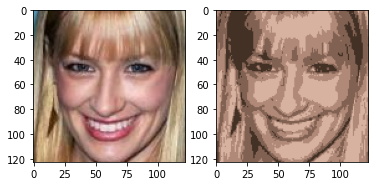

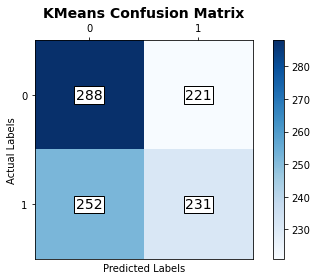

0.5231854838709677


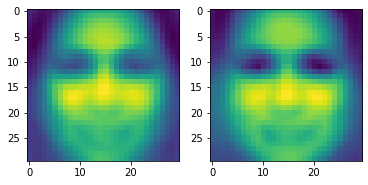

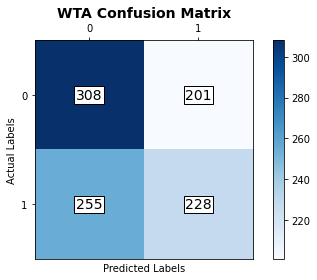

0.5403225806451613


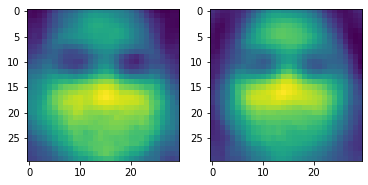

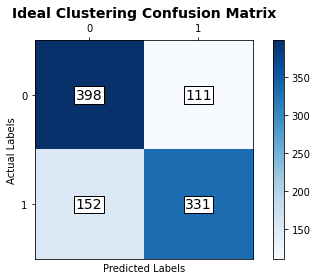

0.7348790322580645


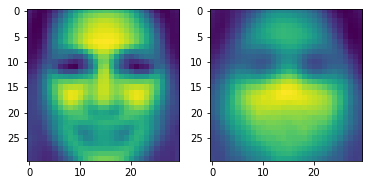

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from evaluation import *
from Dataset import Dataset
from kmeans import kmeans_image_compress, kmeans_image_colorize, kmeans_classify, get_ideal
from wta import wta_classify

import warnings
warnings.filterwarnings("ignore")

# Load normal image
dataset_original = Dataset(dataset_dir=os.path.join("datasets", "face_mask"))
image_fn = dataset_original.get_dataset_fn(
    dataset_original.dataset_dir, "train")[0][0]
image = dataset_original.load_img(image_fn)

# Load conv dataset
dirpath = os.path.join('datasets', 'face_mask_pickled')
dataset_conv = Dataset.load_gzip(
    dir_path=dirpath, file_name='dataset_conv.pkl.gzip')

y_test = dataset_conv.test.y.argmax(axis=1).astype(int)

# KMeans compression
fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.imshow(image)

img, means = kmeans_image_compress(image, 4)
shape = image.shape
ax1.imshow(kmeans_image_colorize(img, means).reshape(shape).astype(int))
fig.show()

# KMeans classification
y_pred, means = kmeans_classify(dataset_conv.test.X, 2)
acc = np.count_nonzero(y_pred == y_test) / len(y_test)
if acc < 0.5:
    y_pred = 1 - y_pred
    acc = 1.0 - acc

plt.figure(3)
cm = get_confusion_matrix(y_test, y_pred, np.unique(y_test))
plot_confusion_matrix(cm, np.unique(y_test), 'KMeans Confusion Matrix')
print(acc)

fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.imshow(means[0].reshape(int(np.sqrt(means[0].shape[0])), -1))
ax1.imshow(means[1].reshape(int(np.sqrt(means[1].shape[0])), -1))
fig.show()

# WTA classification
y_pred, centers = wta_classify(dataset_conv.test.X, 2, lp=0.01)
acc = np.count_nonzero(y_pred == y_test) / len(y_test)
if acc < 0.5:
    y_pred = 1 - y_pred
    acc = 1.0 - acc

plt.figure(4)
cm = get_confusion_matrix(y_test, y_pred, np.unique(y_test))
plot_confusion_matrix(cm, np.unique(y_test), 'WTA Confusion Matrix')
print(acc)

fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.imshow(centers[0].reshape(int(np.sqrt(centers[0].shape[0])), -1))
ax1.imshow(centers[1].reshape(int(np.sqrt(centers[1].shape[0])), -1))
fig.show()

# Ideal means
y_ideal, means = get_ideal(dataset_conv.test.X, y_test)
acc = np.count_nonzero(y_ideal == y_test) / len(y_test)
if acc < 0.5:
    y_ideal = 1 - y_ideal
    acc = 1.0 - acc

plt.figure(5)
cm = get_confusion_matrix(y_test, y_ideal, np.unique(y_test))
plot_confusion_matrix(cm, np.unique(
    y_test), 'Ideal Clustering Confusion Matrix')
print(acc)

fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.imshow(means[0].reshape(int(np.sqrt(means[0].shape[0])), -1))
ax1.imshow(means[1].reshape(int(np.sqrt(means[1].shape[0])), -1))
fig.show()


# 5. Classifier fusion

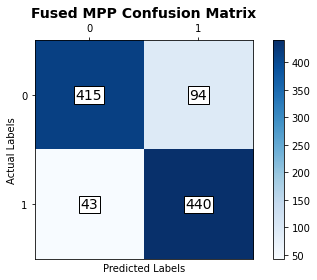

0.8618951612903226


In [17]:
import numpy as np
from fusion import NaiveBayesFuser
from evaluation import *

# cm0 = np.array([
#     [20, 5, 5],
#     [3, 24, 3],
#     [0, 9, 21]
# ])

# cm1 = np.array([
#     [25, 2, 3],
#     [3, 22, 5],
#     [5, 6, 19]
# ])

fuser = NaiveBayesFuser()
fuser.add_matrix(case_1_cm)
fuser.add_matrix(case_2_cm)
fuser.add_matrix(case_3_cm)

fused_y = []
for predictions in zip(case_1_y, case_2_y, case_3_y):
    fused_y.append(fuser.classify(predictions))

fused_y = np.array(fused_y)
fused_cm = get_confusion_matrix(y_test, fused_y, np.unique(y_test))
plot_confusion_matrix(fused_cm, np.unique(y_test), 'Fused MPP Confusion Matrix')
print(np.count_nonzero(fused_y == y_test) / len(y_test))

# 6. Performance evaluation
Note: Use n-fold cross validation to generate confusion matrix and ROC curve if applicable.

# 7. Feedback system
Maybe